In [2]:
# load in the libs
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as p
import pandas as pd
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

import gensim
from gensim import corpora
from gensim.models import LdaModel
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer


In [3]:
# load all csv in the given dataset: https://github.com/megagonlabs/HappyDB
# import the raw data without downloads manually, skip the line that have issues and no header row in CSV file refers to numbers as column names

folder = 'https://raw.githubusercontent.com/megagonlabs/HappyDB/master/happydb/data/'
# this two files seems to be very useful and will be the center of the analysis
cleaned_hm = pd.read_csv(folder+'cleaned_hm.csv', sep = ",",on_bad_lines='skip')
demographic = pd.read_csv(folder+'demographic.csv', sep = ",",on_bad_lines='skip')
original_hm = pd.read_csv(folder+'original_hm.csv', sep = ",",on_bad_lines='skip')
senselabel = pd.read_csv(folder+'senselabel.csv', sep = ",",on_bad_lines='skip')
vad = pd.read_csv(folder+'vad.csv', sep = ",",on_bad_lines='skip')

folder = 'https://raw.githubusercontent.com/megagonlabs/HappyDB/master/happydb/data/topic_dict/'
entertainment_dict = pd.read_csv(folder+'entertainment-dict.csv', sep = ",",on_bad_lines='skip', header=None)
exercise_dict = pd.read_csv(folder+'exercise-dict.csv', sep = ",",on_bad_lines='skip', header=None)
family_dict = pd.read_csv(folder+'family-dict.csv', sep = ",",on_bad_lines='skip', header=None)
food_dict = pd.read_csv(folder+'food-dict.csv', sep = ",",on_bad_lines='skip', header=None)
people_dict = pd.read_csv(folder+'people-dict.csv', sep = ",",on_bad_lines='skip', header=None)
pets_dict = pd.read_csv(folder+'pets-dict.csv', sep = ",",on_bad_lines='skip', header=None)
school_dict = pd.read_csv(folder+'school-dict.csv', sep = ",",on_bad_lines='skip', header=None)
shopping_dict = pd.read_csv(folder+'shopping-dict.csv', sep = ",",on_bad_lines='skip', header=None)
work_dict = pd.read_csv(folder+'work-dict.csv', sep = ",",on_bad_lines='skip', header=None)

In [4]:
cleaned_hm.head(3)

,hmid,wid,reflection_period,original_hm,cleaned_hm,modified,num_sentence,ground_truth_category,predicted_category
0,27673,2053,24h,I went on a successful date with someone I fel...,I went on a successful date with someone I fel...,True,1,NaN,affection
1,27674,2,24h,I was happy when my son got 90% marks in his e...,I was happy when my son got 90% marks in his e...,True,1,NaN,affection
2,27675,1936,24h,I went to the gym this morning and did yoga.,I went to the gym this morning and did yoga.,True,1,NaN,exercise


In [5]:
entertainment_dict.head(3)

,0
0,movie
1,tv
2,film


In [6]:
# a brief invesitage of all the possible info we can use to ask questions
print('cleaned hm:\n', cleaned_hm.columns)
print('demographic:\n', demographic.columns)

cleaned hm:
 Index(['hmid', 'wid', 'reflection_period', 'original_hm', 'cleaned_hm',
       'modified', 'num_sentence', 'ground_truth_category',
       'predicted_category'],
      dtype='object')
demographic:
 Index(['wid', 'age', 'country', 'gender', 'marital', 'parenthood'], dtype='object')


#  Question: How do Happy Moments Vary Across Different Demographics?

Sub-questions:

Are there notable differences in the sentiment of happy moments based on age or marital status?

How does parenthood influence the content or sentiment of happy moments?


# EPA

In [8]:
# Merging datasets on worker id
df = pd.merge(cleaned_hm, demographic, on='wid')
df = df.dropna()
df.shape

(14055, 14)

### Sentimental Analysis

In [9]:
# get the sentiment level of each happy message and returns a sentiment polarity score, >0 refers to positive sentiment, <0 refers to negative
# you can use .sentiment to analyze sentiment, .tags for part-of-speech tagging, .noun_phrases to extract noun phrases, and more.

def get_sentiment(text):
    return TextBlob(text).sentiment.polarity

df['sentiment'] = df['cleaned_hm'].apply(get_sentiment)
df

,hmid,wid,reflection_period,original_hm,cleaned_hm,modified,num_sentence,ground_truth_category,predicted_category,age,country,gender,marital,parenthood,sentiment
6,40281,2053,24h,I played a game for about half an hour.,I played a game for about half an hour.,True,1,leisure,leisure,35,USA,m,single,n,-0.283333
15,32821,2,24h,When my family plan a abroad tour with me,When my family plan a abroad tour with me,True,1,affection,affection,29.0,IND,m,married,y,0.000000
19,34843,2,24h,When my house ready to live with my family,When my house ready to live with my family,True,1,affection,affection,29.0,IND,m,married,y,0.168182
23,37031,2,24h,When my friend meet me today with expensive gi...,When my friend meet me today with expensive gi...,True,1,bonding,bonding,29.0,IND,m,married,y,-0.500000
25,38598,2,24h,I was very happy when my son playing with whol...,I was very happy when my son playing with whol...,True,1,affection,affection,29.0,IND,m,married,y,0.600000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100494,128202,10685,24h,My tooth stopped aching after my dentist visit.,My tooth stopped aching after my dentist visit.,True,1,achievement,achievement,46,USA,f,married,y,0.000000
100496,127705,9044,24h,I took a bath with my husband.,I took a bath with my husband.,True,1,affection,affection,32,USA,f,married,n,0.000000
100526,127748,8880,24h,I got on the scales in the morning and I was 5...,I got on the scales in the morning and I was 5...,True,1,achievement,achievement,58,USA,f,married,n,0.000000
100529,127751,11402,24h,Quite dinner with my wife.,Quite dinner with my wife.,True,1,affection,affection,32,USA,m,married,n,0.000000


In [10]:
# is there any relationship between the sentiment level of happy moment with the age of the person?
# convert age from string to integer and seperate age by 10, add one column "age label" for their catogory
def convert_age_to_int(string):
    try:
        num = int(float(string))
    except:
        num = -9999 # no info
    return num

def age_category(ages):
    bins = [-9999, 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100,  float("inf")]
    labels = ['No Info', '0-10', '10-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90', '90-100', '100+']
    age_categories = pd.cut(ages, bins=bins, labels=labels, right=False, include_lowest=True)
    return age_categories

df['age'] = df['age'].apply(convert_age_to_int)
df['age label'] = age_category(df['age'])
df.head(3)

,hmid,wid,reflection_period,original_hm,cleaned_hm,modified,num_sentence,ground_truth_category,predicted_category,age,country,gender,marital,parenthood,sentiment,age label
6,40281,2053,24h,I played a game for about half an hour.,I played a game for about half an hour.,True,1,leisure,leisure,35,USA,m,single,n,-0.283333,30-40
15,32821,2,24h,When my family plan a abroad tour with me,When my family plan a abroad tour with me,True,1,affection,affection,29,IND,m,married,y,0.000000,20-30
19,34843,2,24h,When my house ready to live with my family,When my house ready to live with my family,True,1,affection,affection,29,IND,m,married,y,0.168182,20-30


import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(_df_0, *['hmid'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(_df_1, *['wid'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(_df_2, *['age'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(_df_3, *['sentiment'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(_df_4, *['hmid'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(_df_5, *['wid'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(_df_6, *['age'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(_df_7, *['sentiment'], **{})
chart

import numpy as np
from google.colab import autoviz

def categorical_histogram(df, colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  df.groupby(colname).size().plot(kind='barh', color=sns.palettes.mpl_palette(mpl_palette_name), figsize=(8*figscale, 4.8*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  return autoviz.MplChart.from_current_mpl_state()

chart = categorical_histogram(_df_8, *['original_hm'], **{})
chart

import numpy as np
from google.colab import autoviz

def categorical_histogram(df, colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  df.groupby(colname).size().plot(kind='barh', color=sns.palettes.mpl_palette(mpl_palette_name), figsize=(8*figscale, 4.8*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  return autoviz.MplChart.from_current_mpl_state()

chart = categorical_histogram(_df_9, *['cleaned_hm'], **{})
chart

import numpy as np
from google.colab import autoviz

def categorical_histogram(df, colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  df.groupby(colname).size().plot(kind='barh', color=sns.palettes.mpl_palette(mpl_palette_name), figsize=(8*figscale, 4.8*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  return autoviz.MplChart.from_current_mpl_state()

chart = categorical_histogram(_df_10, *['ground_truth_category'], **{})
chart

import numpy as np
from google.colab import autoviz

def categorical_histogram(df, colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  df.groupby(colname).size().plot(kind='barh', color=sns.palettes.mpl_palette(mpl_palette_name), figsize=(8*figscale, 4.8*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  return autoviz.MplChart.from_current_mpl_state()

chart = categorical_histogram(_df_11, *['predicted_category'], **{})
chart

import numpy as np
from google.colab import autoviz

def scatter_plots(df, colname_pairs, figscale=1, alpha=.8):
  from matplotlib import pyplot as plt
  plt.figure(figsize=(len(colname_pairs) * 6 * figscale, 6 * figscale))
  for plot_i, (x_colname, y_colname) in enumerate(colname_pairs, start=1):
    ax = plt.subplot(1, len(colname_pairs), plot_i)
    df.plot(kind='scatter', x=x_colname, y=y_colname, s=(32 * figscale), alpha=alpha, ax=ax)
    ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = scatter_plots(_df_12, *[[['hmid', 'wid'], ['wid', 'age'], ['age', 'sentiment']]], **{})
chart

import numpy as np
from google.colab import autoviz

def heatmap(df, x_colname, y_colname, figscale=1, mpl_palette_name='viridis'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  import pandas as pd
  plt.subplots(figsize=(8 * figscale, 8 * figscale))
  df_2dhist = pd.DataFrame({
      x_label: grp[y_colname].value_counts()
      for x_label, grp in df.groupby(x_colname)
  })
  sns.heatmap(df_2dhist, cmap=mpl_palette_name)
  plt.xlabel(x_colname)
  plt.ylabel(y_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = heatmap(_df_13, *['original_hm', 'cleaned_hm'], **{})
chart

import numpy as np
from google.colab import autoviz

def heatmap(df, x_colname, y_colname, figscale=1, mpl_palette_name='viridis'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  import pandas as pd
  plt.subplots(figsize=(8 * figscale, 8 * figscale))
  df_2dhist = pd.DataFrame({
      x_label: grp[y_colname].value_counts()
      for x_label, grp in df.groupby(x_colname)
  })
  sns.heatmap(df_2dhist, cmap=mpl_palette_name)
  plt.xlabel(x_colname)
  plt.ylabel(y_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = heatmap(_df_14, *['cleaned_hm', 'ground_truth_category'], **{})
chart

import numpy as np
from google.colab import autoviz

def heatmap(df, x_colname, y_colname, figscale=1, mpl_palette_name='viridis'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  import pandas as pd
  plt.subplots(figsize=(8 * figscale, 8 * figscale))
  df_2dhist = pd.DataFrame({
      x_label: grp[y_colname].value_counts()
      for x_label, grp in df.groupby(x_colname)
  })
  sns.heatmap(df_2dhist, cmap=mpl_palette_name)
  plt.xlabel(x_colname)
  plt.ylabel(y_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = heatmap(_df_15, *['ground_truth_category', 'predicted_category'], **{})
chart

import numpy as np
from google.colab import autoviz

def heatmap(df, x_colname, y_colname, figscale=1, mpl_palette_name='viridis'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  import pandas as pd
  plt.subplots(figsize=(8 * figscale, 8 * figscale))
  df_2dhist = pd.DataFrame({
      x_label: grp[y_colname].value_counts()
      for x_label, grp in df.groupby(x_colname)
  })
  sns.heatmap(df_2dhist, cmap=mpl_palette_name)
  plt.xlabel(x_colname)
  plt.ylabel(y_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = heatmap(_df_16, *['predicted_category', 'country'], **{})
chart

import numpy as np
from google.colab import autoviz

def violin_plot(df, value_colname, facet_colname, figscale=1, mpl_palette_name='Dark2', **kwargs):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (12 * figscale, 1.2 * figscale * len(df[facet_colname].unique()))
  plt.figure(figsize=figsize)
  sns.violinplot(df, x=value_colname, y=facet_colname, palette=mpl_palette_name, **kwargs)
  sns.despine(top=True, right=True, bottom=True, left=True)
  return autoviz.MplChart.from_current_mpl_state()

chart = violin_plot(_df_17, *['hmid', 'original_hm'], **{'inner': 'stick'})
chart

import numpy as np
from google.colab import autoviz

def violin_plot(df, value_colname, facet_colname, figscale=1, mpl_palette_name='Dark2', **kwargs):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (12 * figscale, 1.2 * figscale * len(df[facet_colname].unique()))
  plt.figure(figsize=figsize)
  sns.violinplot(df, x=value_colname, y=facet_colname, palette=mpl_palette_name, **kwargs)
  sns.despine(top=True, right=True, bottom=True, left=True)
  return autoviz.MplChart.from_current_mpl_state()

chart = violin_plot(_df_18, *['hmid', 'cleaned_hm'], **{'inner': 'stick'})
chart

import numpy as np
from google.colab import autoviz

def violin_plot(df, value_colname, facet_colname, figscale=1, mpl_palette_name='Dark2', **kwargs):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (12 * figscale, 1.2 * figscale * len(df[facet_colname].unique()))
  plt.figure(figsize=figsize)
  sns.violinplot(df, x=value_colname, y=facet_colname, palette=mpl_palette_name, **kwargs)
  sns.despine(top=True, right=True, bottom=True, left=True)
  return autoviz.MplChart.from_current_mpl_state()

chart = violin_plot(_df_19, *['hmid', 'ground_truth_category'], **{'inner': 'stick'})
chart

import numpy as np
from google.colab import autoviz

def violin_plot(df, value_colname, facet_colname, figscale=1, mpl_palette_name='Dark2', **kwargs):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (12 * figscale, 1.2 * figscale * len(df[facet_colname].unique()))
  plt.figure(figsize=figsize)
  sns.violinplot(df, x=value_colname, y=facet_colname, palette=mpl_palette_name, **kwargs)
  sns.despine(top=True, right=True, bottom=True, left=True)
  return autoviz.MplChart.from_current_mpl_state()

chart = violin_plot(_df_20, *['hmid', 'predicted_category'], **{'inner': 'stick'})
chart

import numpy as np
from google.colab import autoviz

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (10 * figscale, 5.2 * figscale)
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(_df_21, *['num_sentence', 'hmid', 'original_hm'], **{})
chart

import numpy as np
from google.colab import autoviz

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (10 * figscale, 5.2 * figscale)
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(_df_22, *['num_sentence', 'hmid', 'cleaned_hm'], **{})
chart

import numpy as np
from google.colab import autoviz

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (10 * figscale, 5.2 * figscale)
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(_df_23, *['num_sentence', 'hmid', 'ground_truth_category'], **{})
chart

import numpy as np
from google.colab import autoviz

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (10 * figscale, 5.2 * figscale)
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(_df_24, *['num_sentence', 'hmid', 'predicted_category'], **{})
chart

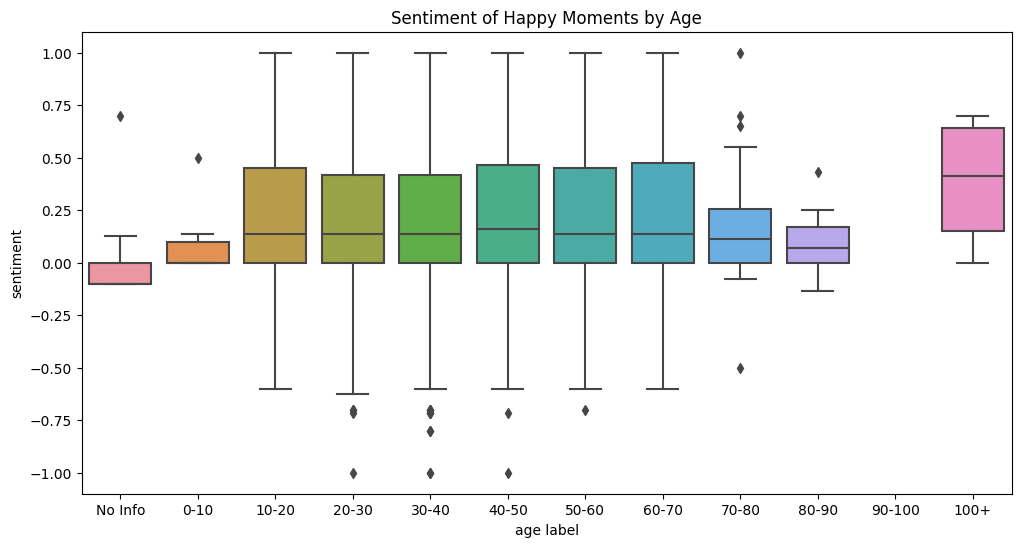

In [11]:
# Sentiment by Age
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='age label', y='sentiment')
plt.title('Sentiment of Happy Moments by Age')
plt.show()

# Based on the box plot's trend, it appears that individuals with notably extended lifespans (age >=100) express more positive sentiment in their happy messages.
# Meanwhile, the positive sentiments in happy messages from people in other age groups show negligible statistical differences.

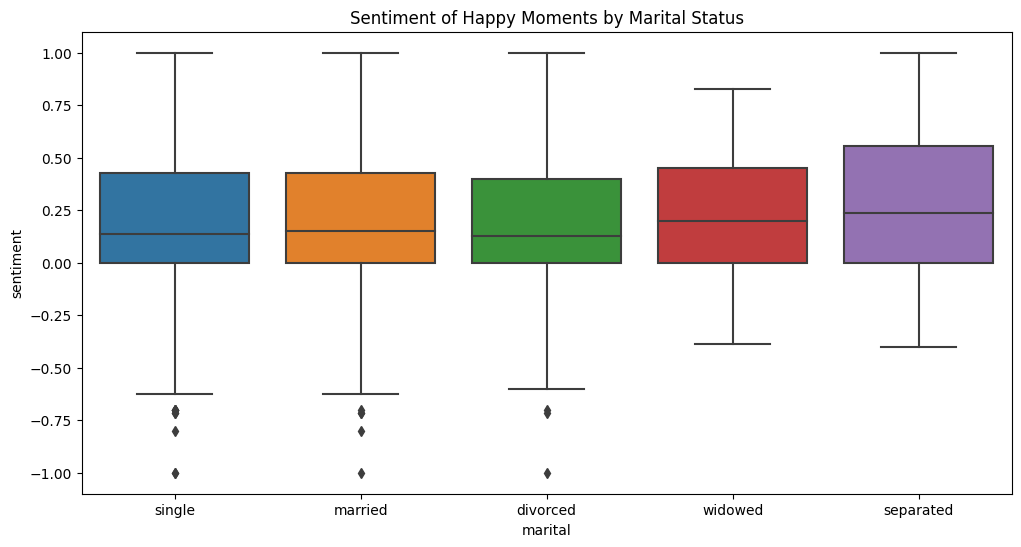

In [12]:
# Sentiment by Marital Status
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='marital', y='sentiment')
plt.title('Sentiment of Happy Moments by Marital Status')
plt.show()

# From the trend observed in the box plot, individuals with a marital status of "separated" appear to have the highest median positive sentiment.
# However, overall, sentiment levels don't vary significantly across different marital statuses.

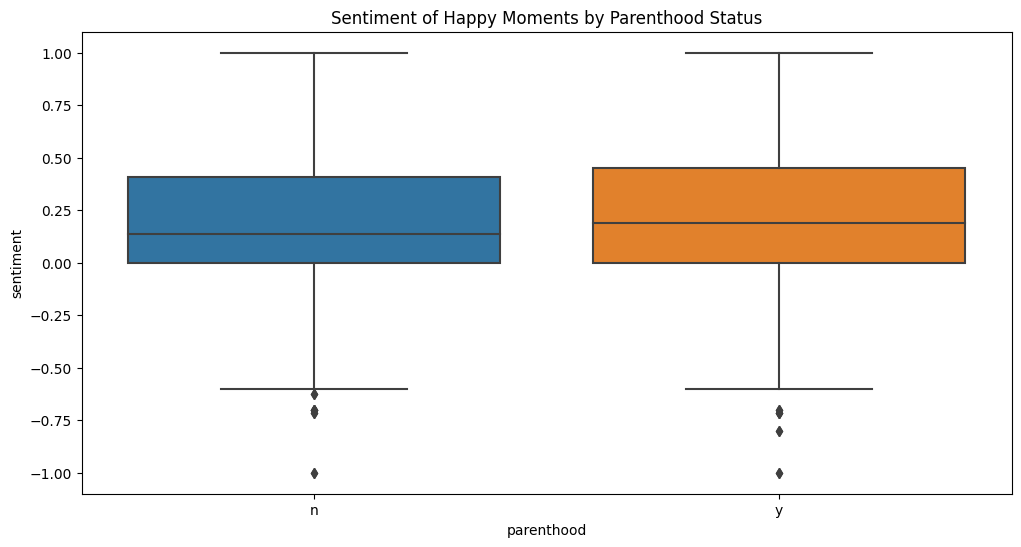

In [13]:
# Sentiment by Parenthood
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='parenthood', y='sentiment')
plt.title('Sentiment of Happy Moments by Parenthood Status')
plt.show()

# From the trend observed in the box plot, individuals with a parenthood status of "yes" appear to have higher median positive sentiment.
# However, overall, sentiment levels don't vary significantly across different parenthood statuses.

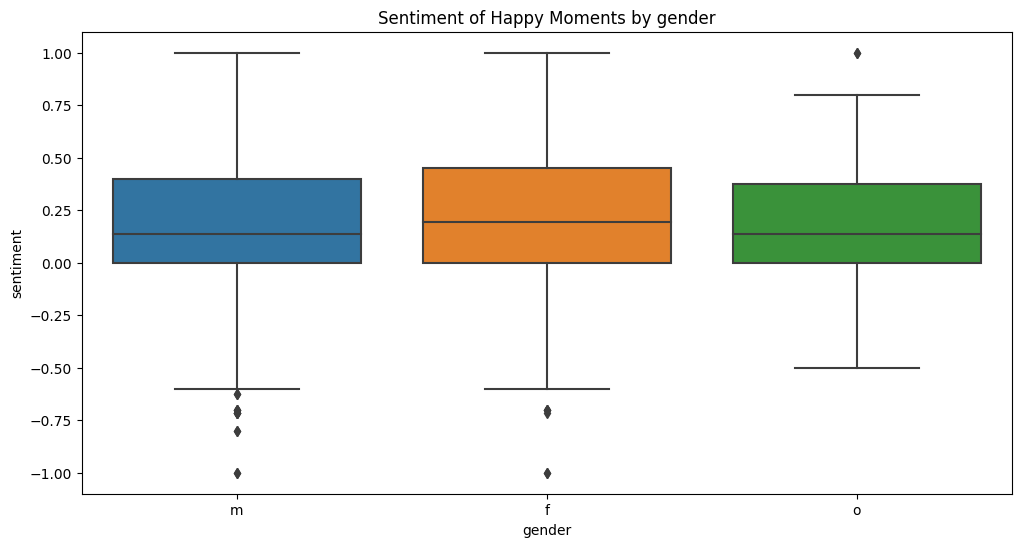

In [14]:
# Sentiment by gender
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='gender', y='sentiment')
plt.title('Sentiment of Happy Moments by gender')
plt.show()

# From the trend observed in the box plot, individuals with a parenthood status of "female" appear to have higher median positive sentiment.
# However, overall, sentiment levels don't vary significantly across different gender statuses.

In [15]:
df.columns

Index(['hmid', 'wid', 'reflection_period', 'original_hm', 'cleaned_hm',
       'modified', 'num_sentence', 'ground_truth_category',
       'predicted_category', 'age', 'country', 'gender', 'marital',
       'parenthood', 'sentiment', 'age label'],
      dtype='object')

### clustering

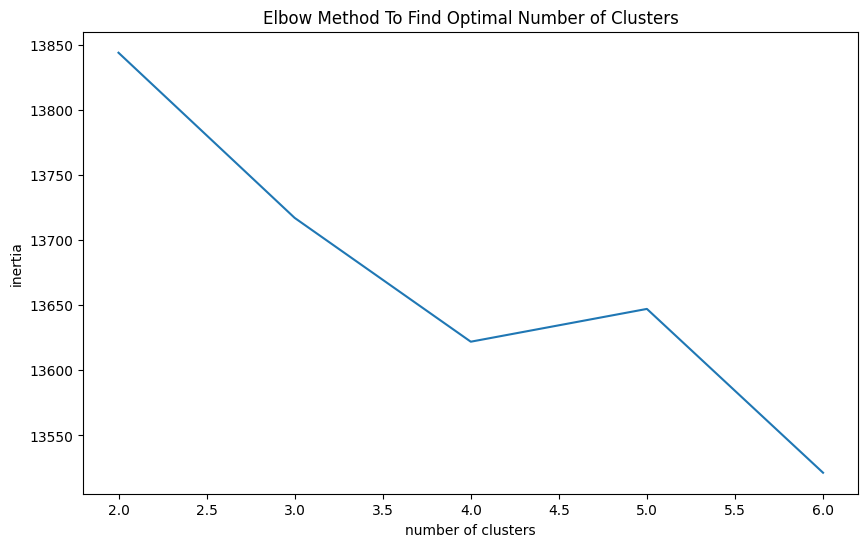

In [16]:
# The elbow method helps you select an appropriate number of clusters by examining how the within-cluster sum of squares(inertia) changes as you increase the number of clusters.
# TfidfVectorizer from scikit-learn to convert the text data in the 'cleaned_hm' column of your DataFrame into TF-IDF vectors.
# stop_words='english' is used to remove common English stop words from the text

vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(df['cleaned_hm'])

num_clusters = []
inertia = []
# loop through 2 to 6 clusters
for k in np.arange(2, 7):
    model = KMeans(n_clusters=k, init='k-means++', max_iter=100, n_init=1)
    model.fit(X)
    num_clusters += [k]
    inertia += [model.inertia_]

plt.figure(figsize=(10,6))
plt.plot(num_clusters, inertia, )
plt.xlabel('number of clusters')
plt.ylabel('inertia')
plt.title('Elbow Method To Find Optimal Number of Clusters')
plt.show()

# In the plot, you'll typically see inertia decreasing steeply initially and then starting to level off. The point where it levels off is the elbow, suggesting the number of clusters to choose.
# based on the plot, 4 clusters seems to be a good chice

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 14055 samples in 0.089s...
[t-SNE] Computed neighbors for 14055 samples in 128.534s...
[t-SNE] Computed conditional probabilities for sample 1000 / 14055
[t-SNE] Computed conditional probabilities for sample 2000 / 14055
[t-SNE] Computed conditional probabilities for sample 3000 / 14055
[t-SNE] Computed conditional probabilities for sample 4000 / 14055
[t-SNE] Computed conditional probabilities for sample 5000 / 14055
[t-SNE] Computed conditional probabilities for sample 6000 / 14055
[t-SNE] Computed conditional probabilities for sample 7000 / 14055
[t-SNE] Computed conditional probabilities for sample 8000 / 14055
[t-SNE] Computed conditional probabilities for sample 9000 / 14055
[t-SNE] Computed conditional probabilities for sample 10000 / 14055
[t-SNE] Computed conditional probabilities for sample 11000 / 14055
[t-SNE] Computed conditional probabilities for sample 12000 / 14055
[t-SNE] Computed conditional probabilities for s

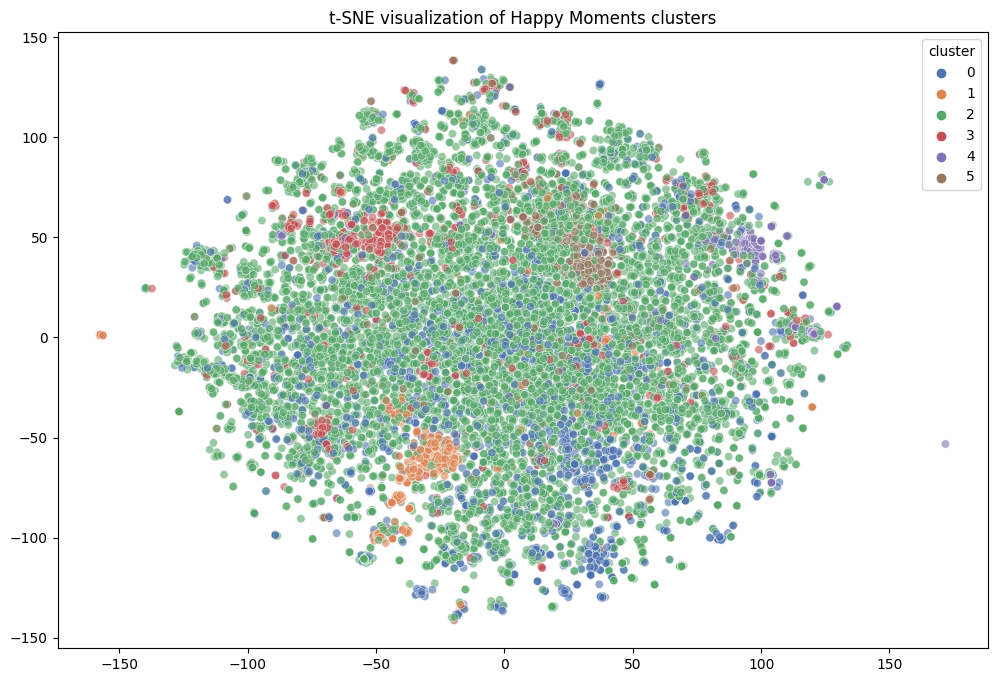

In [17]:
df['cluster'] = model.labels_
tsne = TSNE(verbose=1, perplexity=30, n_iter=3000)
tsne_results = tsne.fit_transform(X.toarray())

# Visualize clusters
plt.figure(figsize=(12,8))
sns.scatterplot(x=tsne_results[:,0], y=tsne_results[:,1], hue=df['cluster'], palette="deep", legend="full", alpha=0.6)
plt.title('t-SNE visualization of Happy Moments clusters')
plt.show()

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 99 samples in 0.000s...
[t-SNE] Computed neighbors for 99 samples in 0.048s...
[t-SNE] Computed conditional probabilities for sample 99 / 99
[t-SNE] Mean sigma: 0.201411
[t-SNE] KL divergence after 250 iterations with early exaggeration: 48.986427
[t-SNE] KL divergence after 3000 iterations: -0.131041


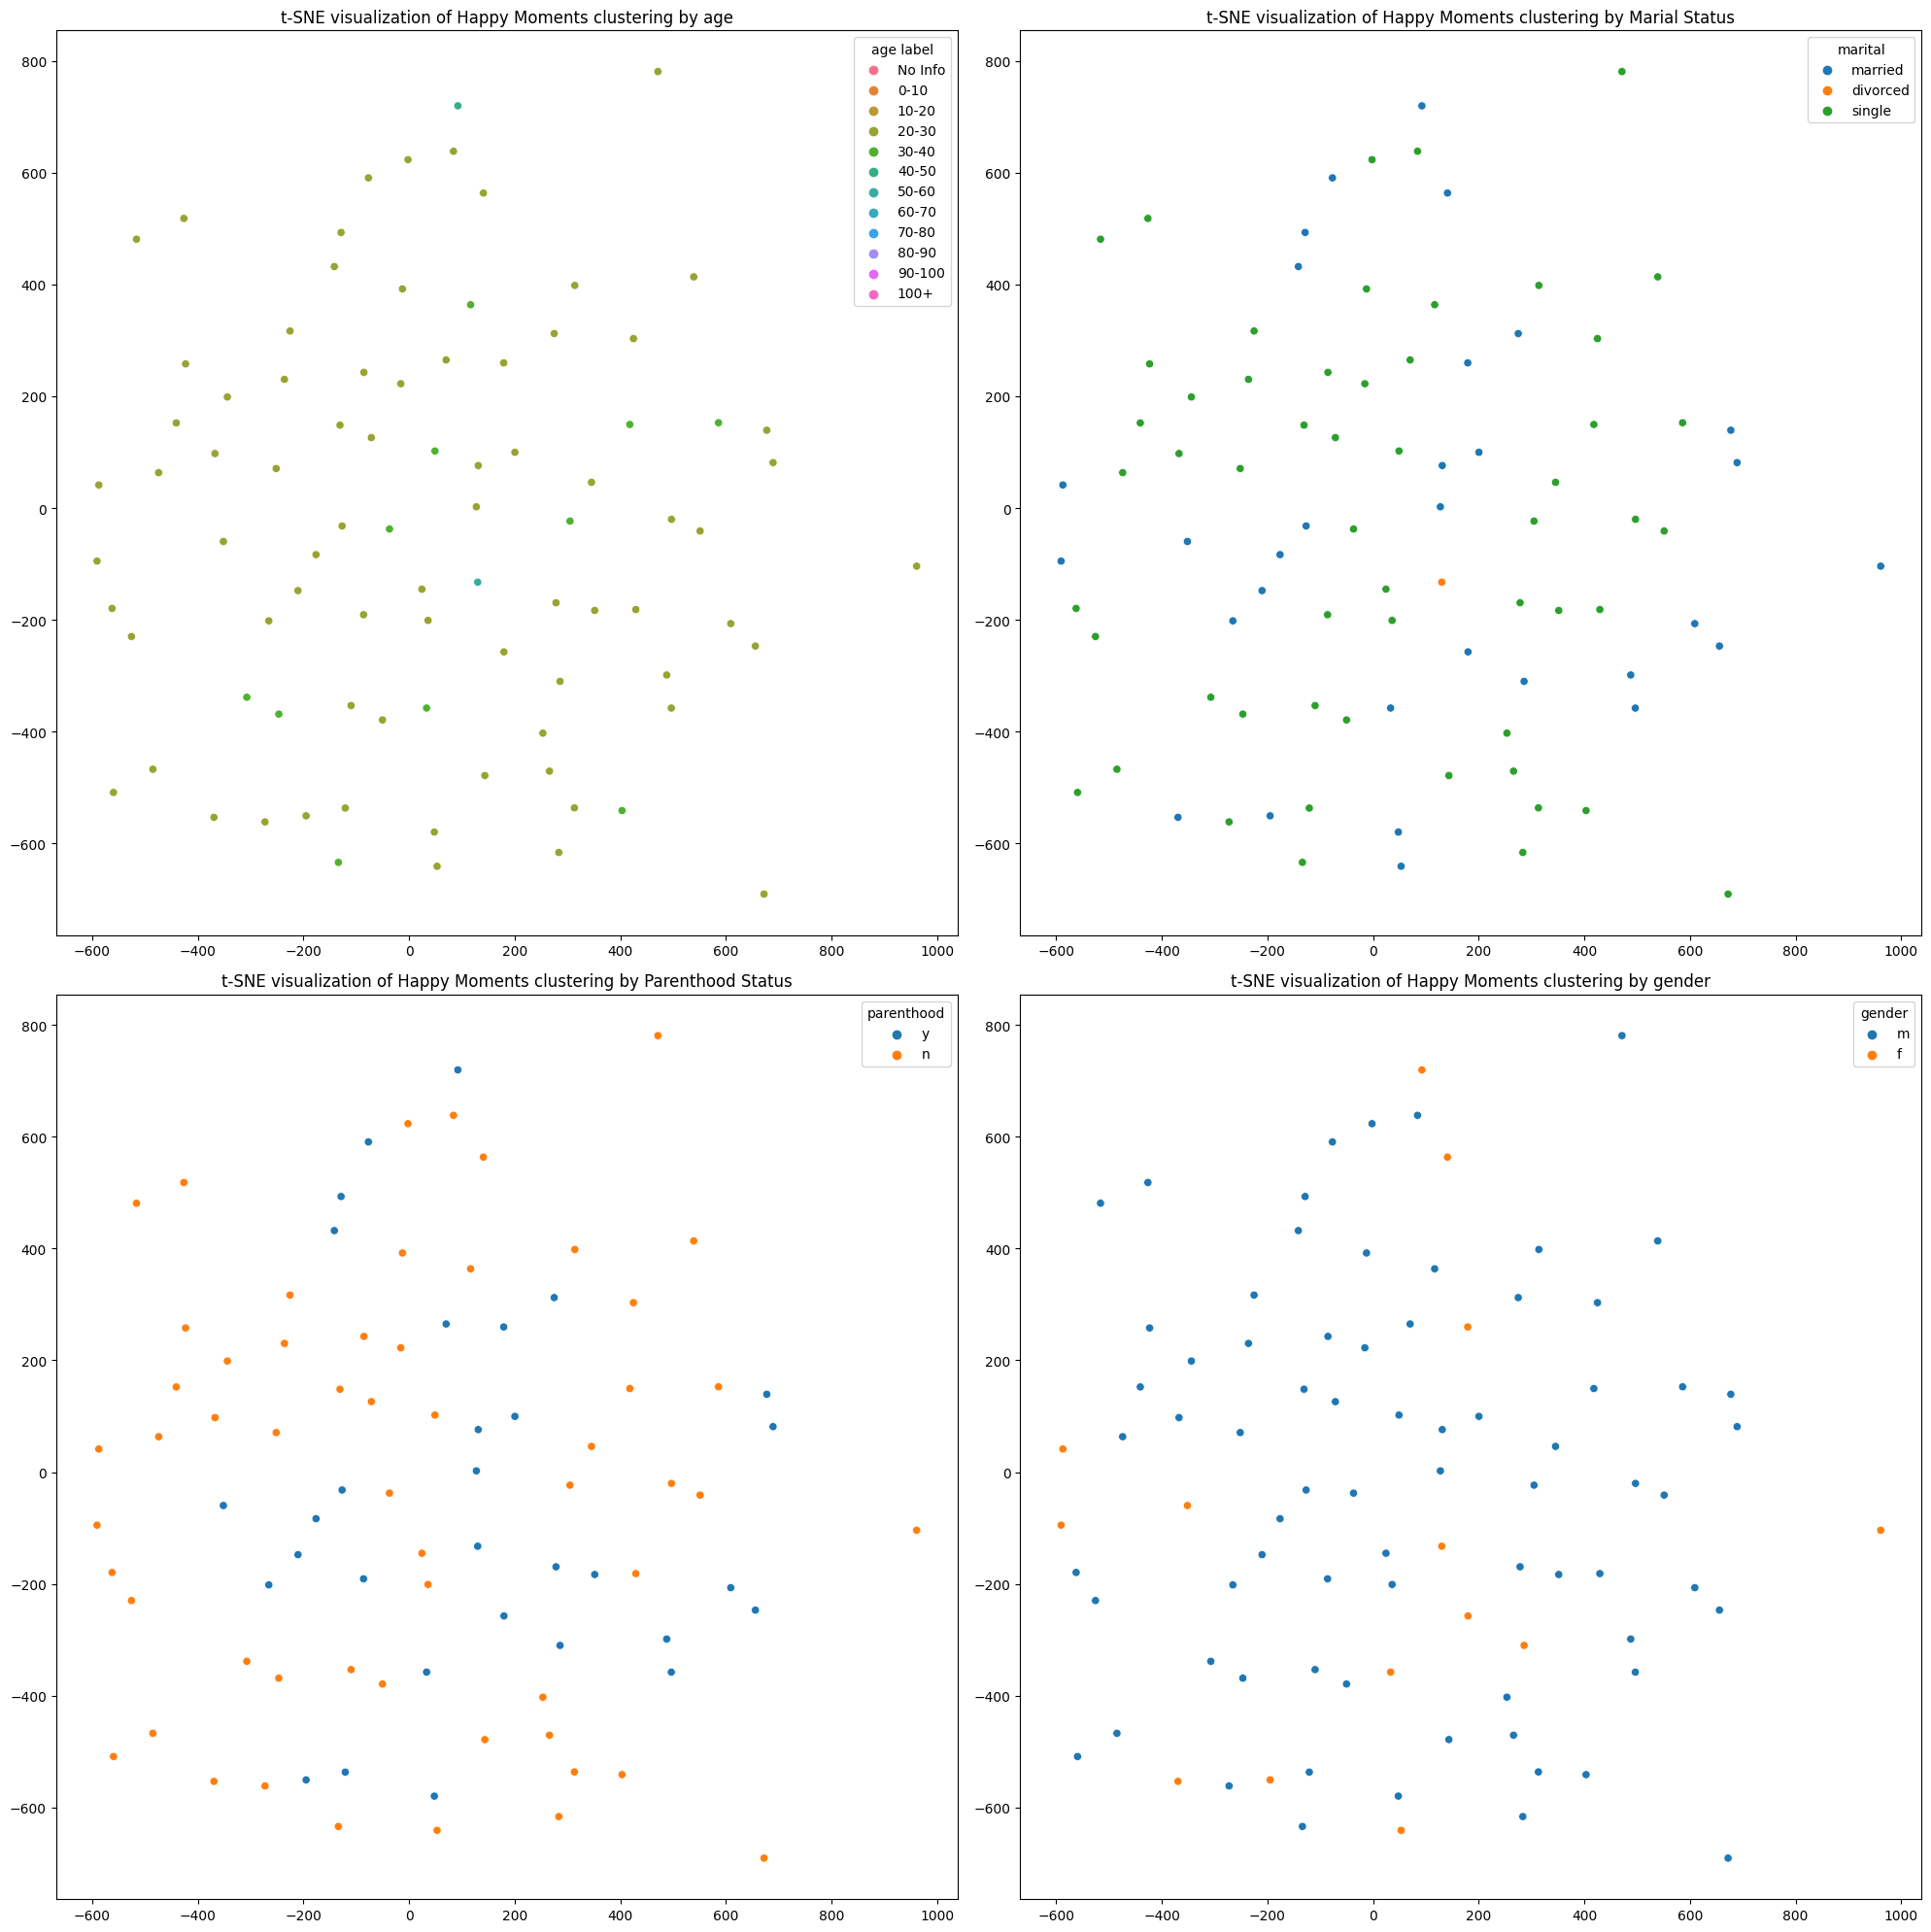

In [18]:
# using t-Distributed Stochastic Neighbor Embedding (t-SNE) for dimensionality reduction and visualization of your data in a 2D space.
# visualizing the clustering of Happy Moments data by different demographic factors (age, marital status, parenthood status, and gender)
# hue colors the points based on each factors, but we do not observe obvious clusters based on factors like age, marital status, parenthood status, nor gen
df_part = df[1:100]
X = vectorizer.fit_transform(df_part['cleaned_hm'])

tsne = TSNE(verbose=1, perplexity=30, n_iter=3000)
tsne_results = tsne.fit_transform(X.toarray())

fig, axs = plt.subplots(2, 2, figsize=(20, 20))

sns.scatterplot(x=tsne_results[:, 0], y=tsne_results[:, 1], hue = df_part['age label'],ax=axs[0, 0])
axs[0, 0].set_title('t-SNE visualization of Happy Moments clustering by age')

sns.scatterplot(x=tsne_results[:, 0], y=tsne_results[:, 1], hue = df_part['marital'],ax=axs[0, 1])
axs[0, 1].set_title('t-SNE visualization of Happy Moments clustering by Marial Status')

sns.scatterplot(x=tsne_results[:, 0], y=tsne_results[:, 1], hue = df_part['parenthood'],ax=axs[1, 0])
axs[1, 0].set_title('t-SNE visualization of Happy Moments clustering by Parenthood Status')

sns.scatterplot(x=tsne_results[:, 0], y=tsne_results[:, 1], hue = df_part['gender'],ax=axs[1, 1])
axs[1, 1].set_title('t-SNE visualization of Happy Moments clustering by gender')

plt.tight_layout()

plt.show()


### topic modeling

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
# tokneize the happy message for further analysis
# Lemmatization is the process of reducing words to their base or dictionary form (e.g., "running" to "run"). This helps in reducing word variations.

stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    # Inside the preprocess function, by using Gensim's simple_preprocess function. Tokenization is the process of splitting text into individual words or tokens.
    tokens = gensim.utils.simple_preprocess(text)
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
    return tokens

df['tokens'] = df['cleaned_hm'].apply(preprocess)
df

,hmid,wid,reflection_period,original_hm,cleaned_hm,modified,num_sentence,ground_truth_category,predicted_category,age,country,gender,marital,parenthood,sentiment,age label,cluster,tokens
6,40281,2053,24h,I played a game for about half an hour.,I played a game for about half an hour.,True,1,leisure,leisure,35,USA,m,single,n,-0.283333,30-40,3,"[played, game, half, hour]"
15,32821,2,24h,When my family plan a abroad tour with me,When my family plan a abroad tour with me,True,1,affection,affection,29,IND,m,married,y,0.000000,20-30,3,"[family, plan, abroad, tour]"
19,34843,2,24h,When my house ready to live with my family,When my house ready to live with my family,True,1,affection,affection,29,IND,m,married,y,0.168182,20-30,3,"[house, ready, live, family]"
23,37031,2,24h,When my friend meet me today with expensive gi...,When my friend meet me today with expensive gi...,True,1,bonding,bonding,29,IND,m,married,y,-0.500000,20-30,3,"[friend, meet, today, expensive, gift]"
25,38598,2,24h,I was very happy when my son playing with whol...,I was very happy when my son playing with whol...,True,1,affection,affection,29,IND,m,married,y,0.600000,20-30,1,"[happy, son, playing, whole, day]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100494,128202,10685,24h,My tooth stopped aching after my dentist visit.,My tooth stopped aching after my dentist visit.,True,1,achievement,achievement,46,USA,f,married,y,0.000000,40-50,3,"[tooth, stopped, aching, dentist, visit]"
100496,127705,9044,24h,I took a bath with my husband.,I took a bath with my husband.,True,1,affection,affection,32,USA,f,married,n,0.000000,30-40,3,"[took, bath, husband]"
100526,127748,8880,24h,I got on the scales in the morning and I was 5...,I got on the scales in the morning and I was 5...,True,1,achievement,achievement,58,USA,f,married,n,0.000000,50-60,2,"[got, scale, morning, lb, lighter]"
100529,127751,11402,24h,Quite dinner with my wife.,Quite dinner with my wife.,True,1,affection,affection,32,USA,m,married,n,0.000000,30-40,3,"[quite, dinner, wife]"


In [ ]:
# for each unique group of people under each demographic factor, find the top 5 words in their happy message

# extracting the top words associated with each topic in an LDA model
def get_top_words(lda_model, num_words=5):
    top_words = {}
    # lda_model returns a dictionary where each key represents a topic index, and the corresponding value is a list of the top words associated with that topic
    # For each topic, it splits the topic representation into individual words and their probabilities and stores them in the top_words dictionary
    # the default output of lda_model.print_topics() is in the format "0.123*word1 + 0.234*word2"
    for idx, topic in lda_model.print_topics(-1):
        words = []
        # split by * and removes any double quotes or spaces from the word
        for word_prob in topic.split('+'):
            word = word_prob.split('*')[1].strip('" ')
            words.append(word)
        # extracts the first num_words from the list
        top_words[idx] = words[:num_words]
    return top_words

# performing LDA topic modeling on a collection of tokenized texts and extracting the top words for each topic
def get_lda_topics(tokens, num_topics=5, top_words_count=5):
    # the dictionary will serve as the vocabulary for the LDA model, mapping each unique word to a unique integer ID
    dictionary = corpora.Dictionary(tokens)
    # converts the tokenized texts into a corpus of document-term frequency vectors using the dictionary, each tuple consists of a word's integer ID and its frequency in the document
    corpus = [dictionary.doc2bow(text) for text in tokens]
    lda_model = gensim.models.LdaMulticore(corpus, num_topics=num_topics, id2word=dictionary, passes=2, workers=2)
    top_words = get_top_words(lda_model, top_words_count)
    return top_words

# Iterates through the unique groups for each demo, extracts the top 5 words within that group
demographics = ['age label', 'marital', 'parenthood', 'gender']
factors = []
labels = []
topics_his = []
for demo in demographics:
    groups = df[demo].unique()
    for group in groups:
        group_tokens = df[df[demo] == group]['tokens'].tolist()
        topics = get_lda_topics(group_tokens, 5, 5)
        for idx, words in topics.items():
            for word in words:
                factors += [demo]
                labels += [group]
                topics_his += [word]


In [ ]:
lda_df = pd.DataFrame()
lda_df['demo factor'] = factors
lda_df['group'] = labels
lda_df['topics'] = topics_his
lda_df

,demo factor,group,topics
0,age label,30-40,made
1,age label,30-40,work
2,age label,30-40,happy
3,age label,30-40,week
4,age label,30-40,able
...,...,...,...
520,gender,o,day
521,gender,o,cool
522,gender,o,today
523,gender,o,last


In [ ]:
df.head(5)

,hmid,wid,reflection_period,original_hm,cleaned_hm,modified,num_sentence,ground_truth_category,predicted_category,age,country,gender,marital,parenthood,sentiment,age label,cluster,tokens
6,40281,2053,24h,I played a game for about half an hour.,I played a game for about half an hour.,True,1,leisure,leisure,35,USA,m,single,n,-0.283333,30-40,3,"[played, game, half, hour]"
15,32821,2,24h,When my family plan a abroad tour with me,When my family plan a abroad tour with me,True,1,affection,affection,29,IND,m,married,y,0.000000,20-30,3,"[family, plan, abroad, tour]"
19,34843,2,24h,When my house ready to live with my family,When my house ready to live with my family,True,1,affection,affection,29,IND,m,married,y,0.168182,20-30,3,"[house, ready, live, family]"
23,37031,2,24h,When my friend meet me today with expensive gi...,When my friend meet me today with expensive gi...,True,1,bonding,bonding,29,IND,m,married,y,-0.500000,20-30,3,"[friend, meet, today, expensive, gift]"
25,38598,2,24h,I was very happy when my son playing with whol...,I was very happy when my son playing with whol...,True,1,affection,affection,29,IND,m,married,y,0.600000,20-30,1,"[happy, son, playing, whole, day]"


In [ ]:
from collections import Counter
list_of_lists = df[0:100]['tokens']
flat_list = [item for sublist in list_of_lists for item in sublist]

# Get unique words and their counts
word_counts = Counter(flat_list)
word_counts_check = dict(list(word_counts.items())[:5])
print(word_counts_check)

{'played': 2, 'game': 1, 'half': 1, 'hour': 2, 'family': 8}


In [ ]:
# visualize the most frequently used 10 words for each unique group in each demographic factor
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(stop_words='english', max_features=10)
top_words = {}

# Loop over demographic columns
for column in ['age label', 'marital', 'parenthood', 'gender']:
    top_words[column] = {}
    for group in df[column].unique():
        # when demographic column matches the current group
        group_df = df[df[column] == group]
        # Get unique words and their counts
        list_of_lists = group_df['tokens']
        flat_list = [item for sublist in list_of_lists for item in sublist]
        word_counts = Counter(flat_list)
        words = list(word_counts.keys())[0:10]
        counts = list(word_counts.values())[0:10]

        # Store top 20 words and their counts for each group
        top_words[column][group] = dict(zip(words, counts))

top_words

{'age label': {'30-40': {'played': 65,
   'game': 158,
   'half': 18,
   'hour': 110,
   'husband': 185,
   'work': 398,
   'finally': 153,
   'picked': 10,
   'back': 120,
   'working': 57},
  '20-30': {'family': 389,
   'plan': 40,
   'abroad': 24,
   'tour': 44,
   'house': 160,
   'ready': 62,
   'live': 52,
   'friend': 969,
   'meet': 69,
   'today': 271},
  '50-60': {'made': 67,
   'vacation': 8,
   'plan': 6,
   'daughter': 51,
   'today': 40,
   'florida': 2,
   'july': 1,
   'weekly': 1,
   'high': 6,
   'score': 2},
  '40-50': {'going': 46,
   'beach': 8,
   'child': 27,
   'laying': 2,
   'umbrella': 1,
   'good': 98,
   'snack': 1,
   'cold': 5,
   'drink': 7,
   'music': 16},
  '70-80': {'son': 4,
   'surprised': 1,
   'morning': 1,
   'waking': 1,
   'home': 1,
   'made': 4,
   'pancake': 1,
   'breakfast': 1,
   'ate': 1,
   'delicious': 1},
  '60-70': {'picked': 1,
   'daughter': 15,
   'airport': 1,
   'fun': 9,
   'good': 20,
   'conversation': 2,
   'way': 3,
   'ho

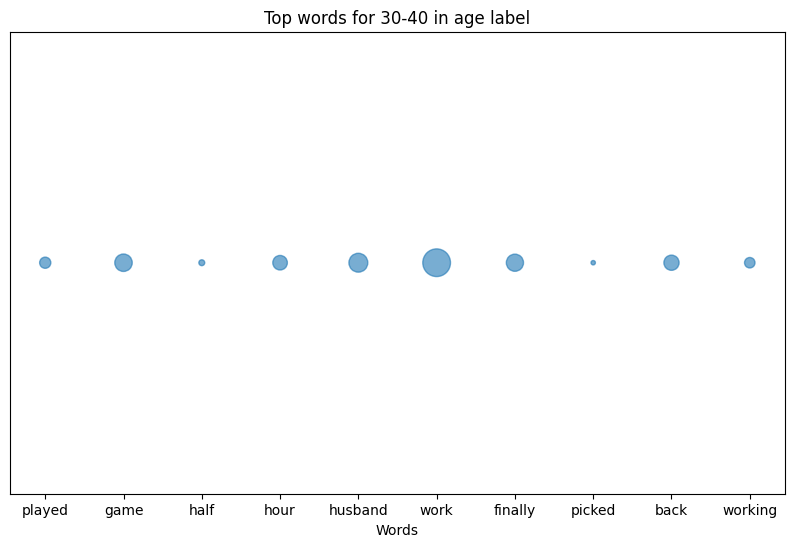

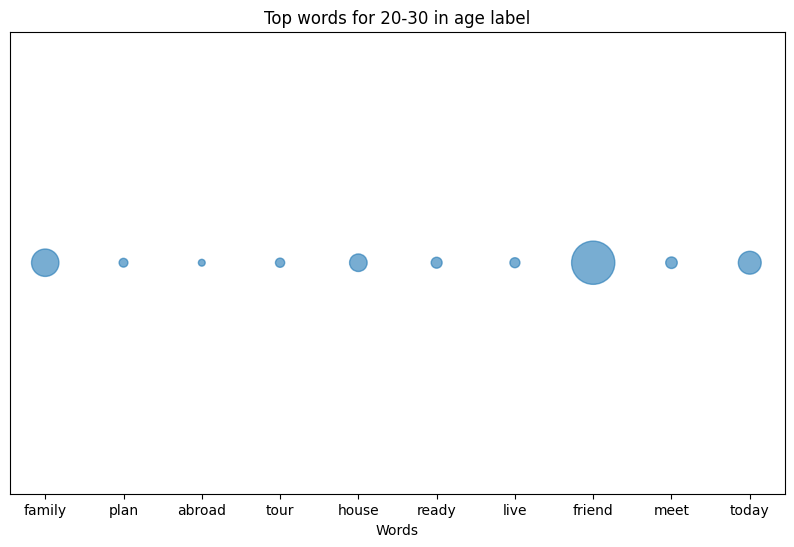

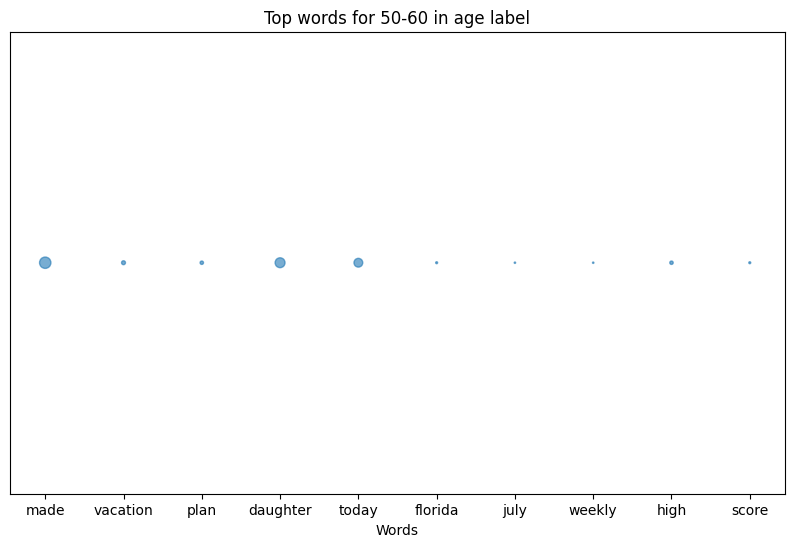

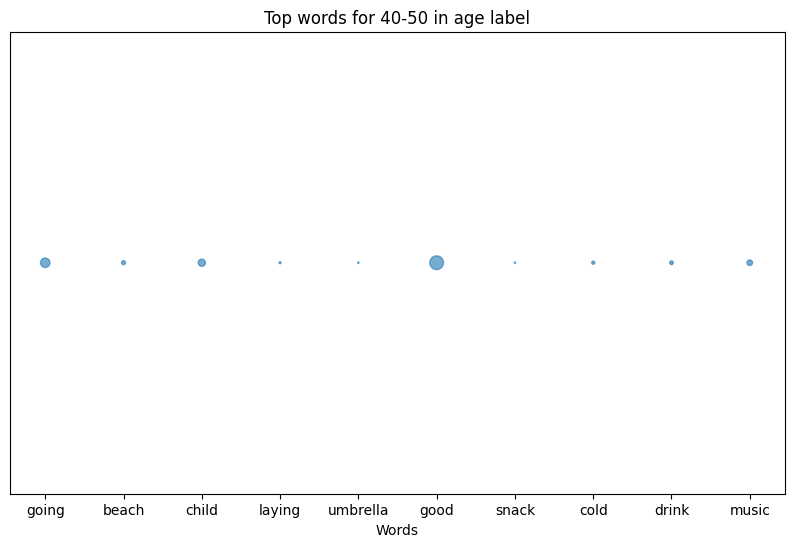

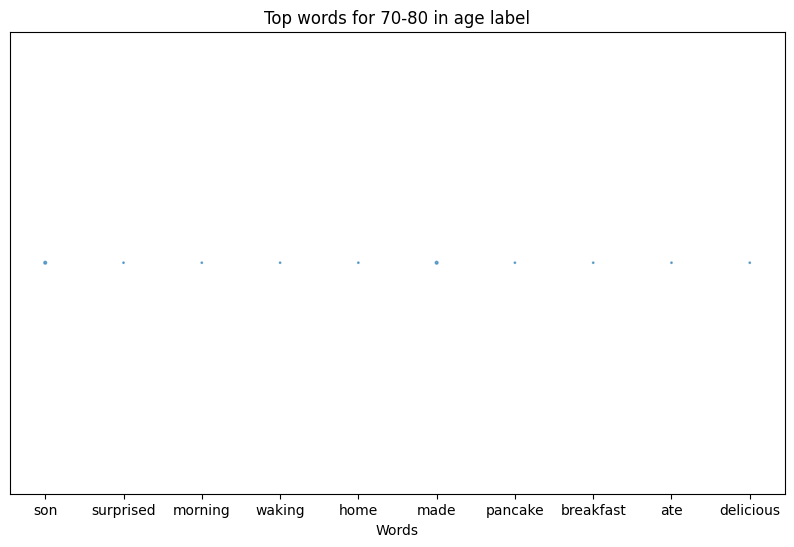

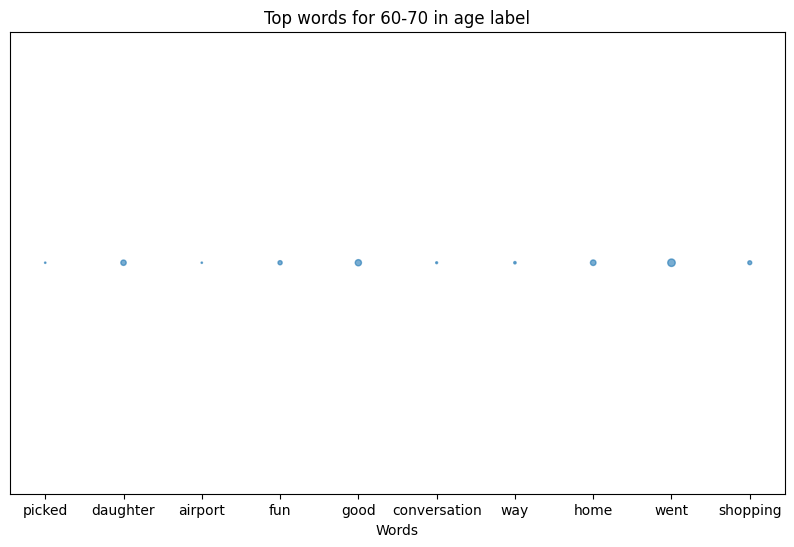

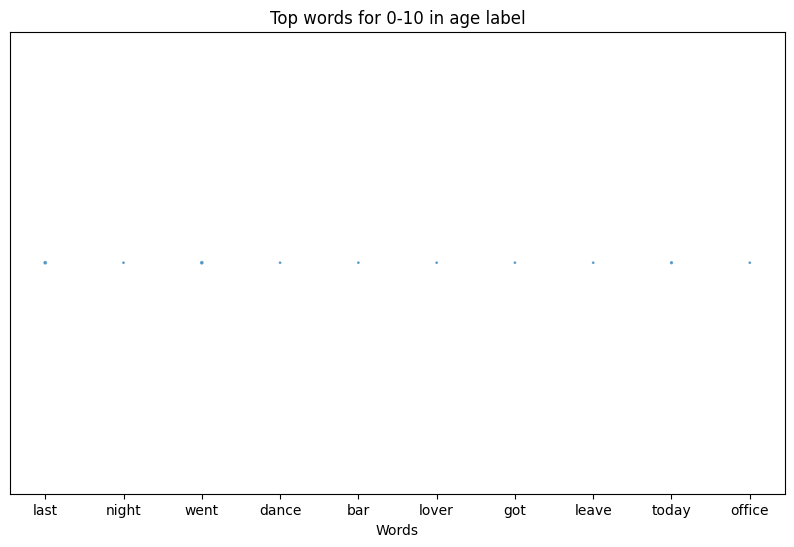

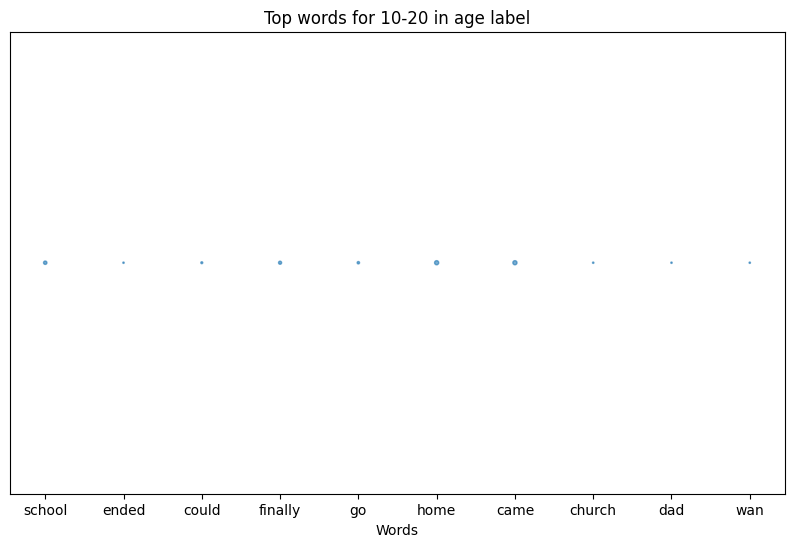

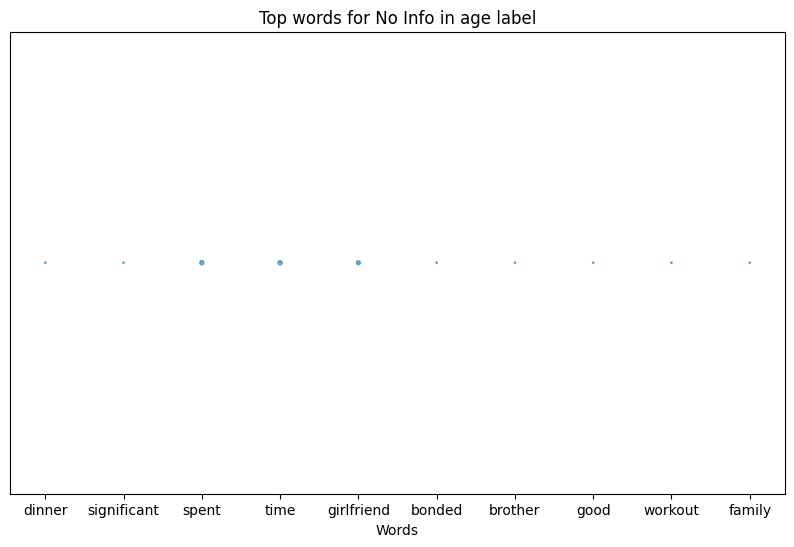

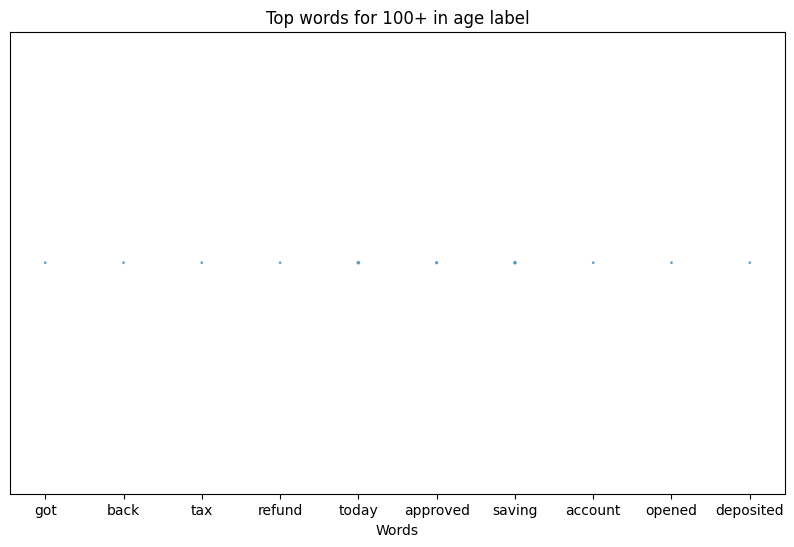

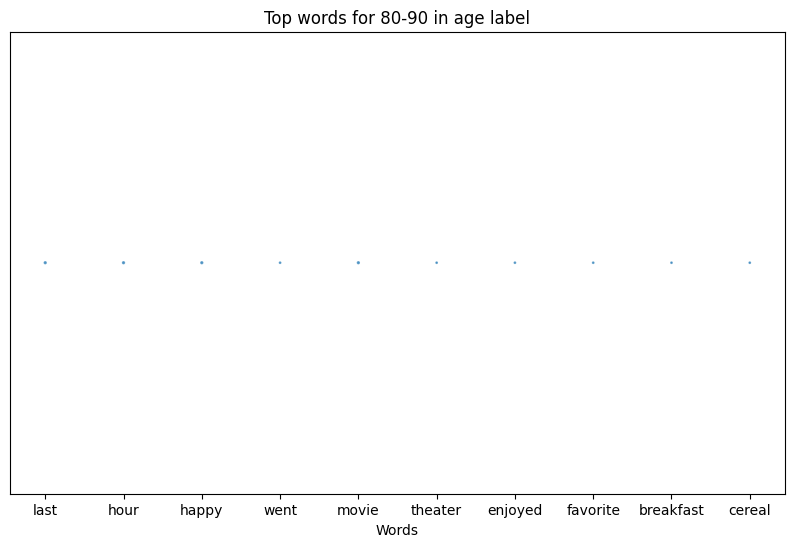

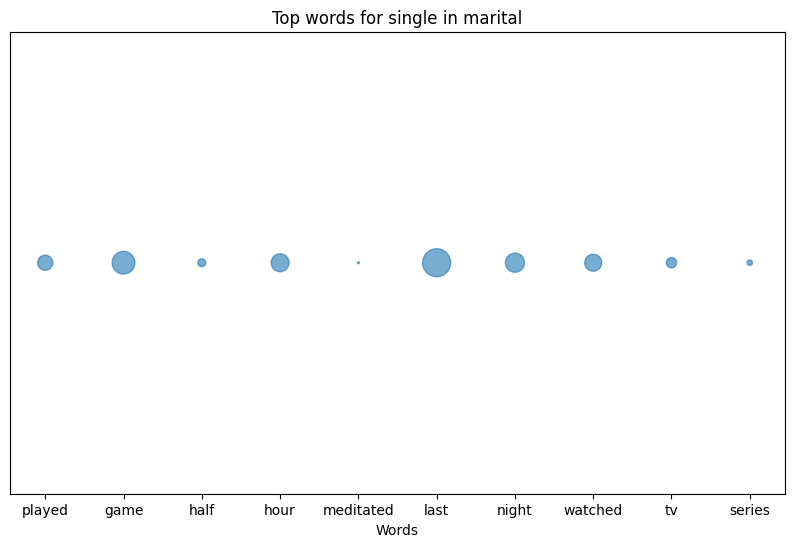

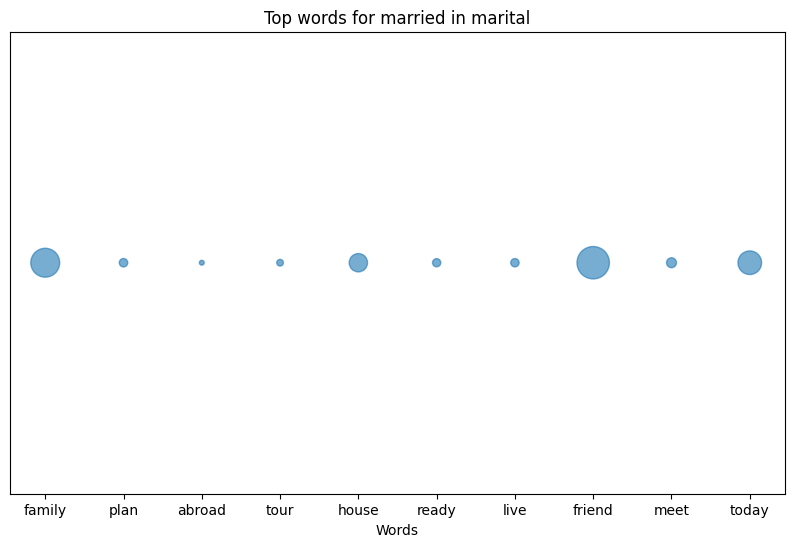

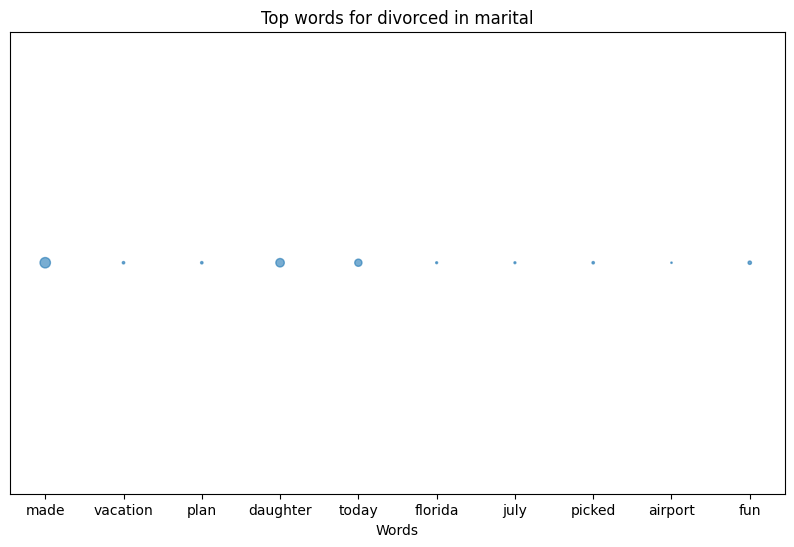

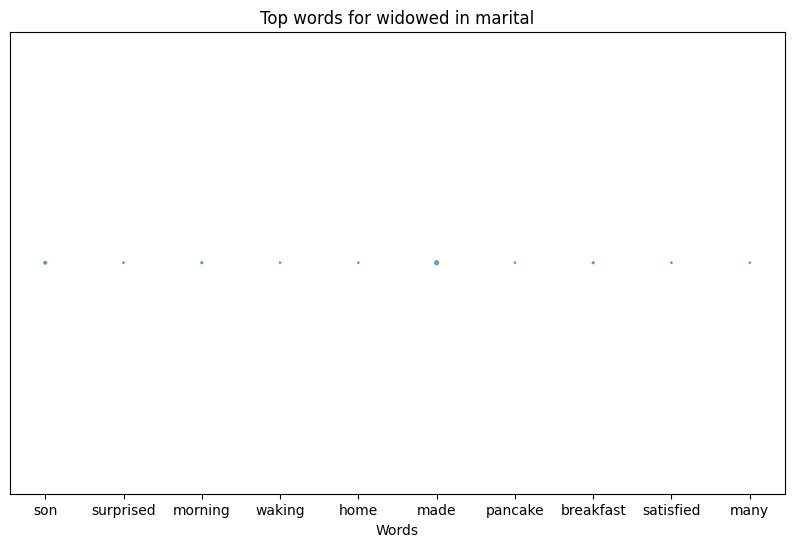

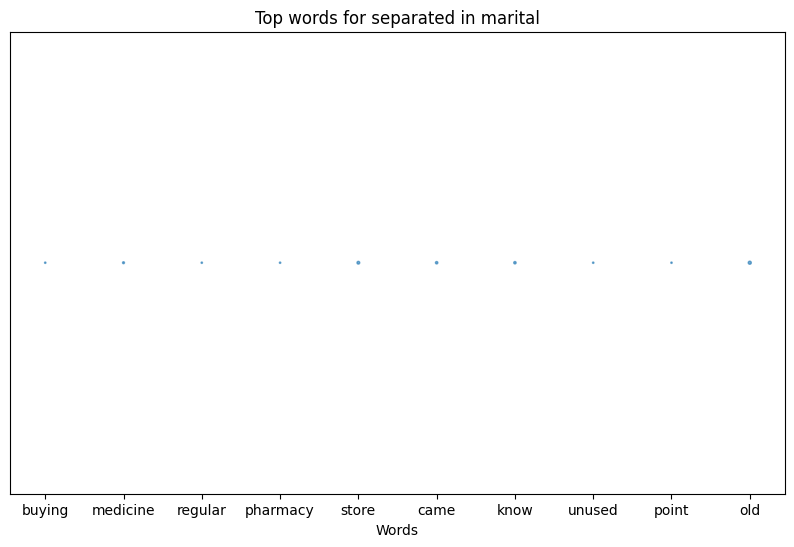

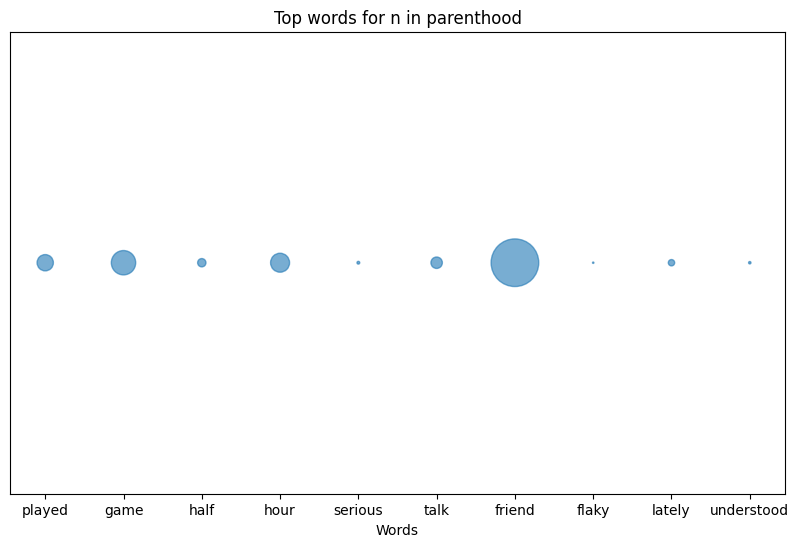

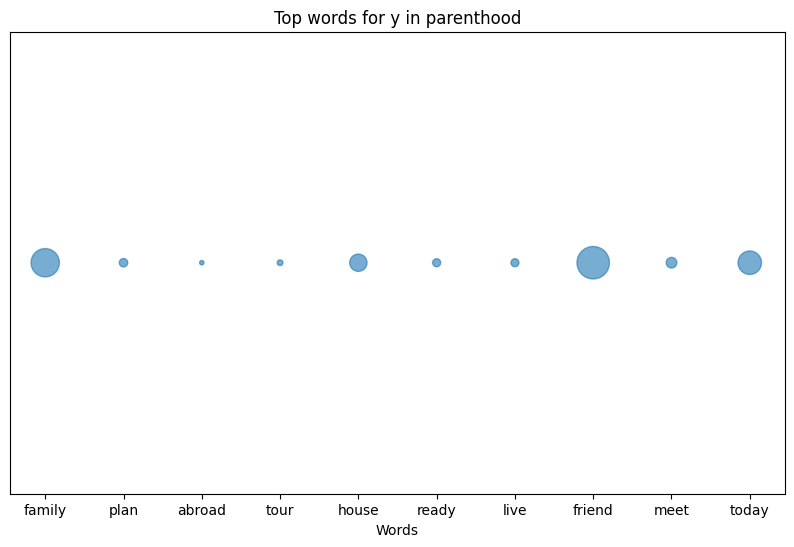

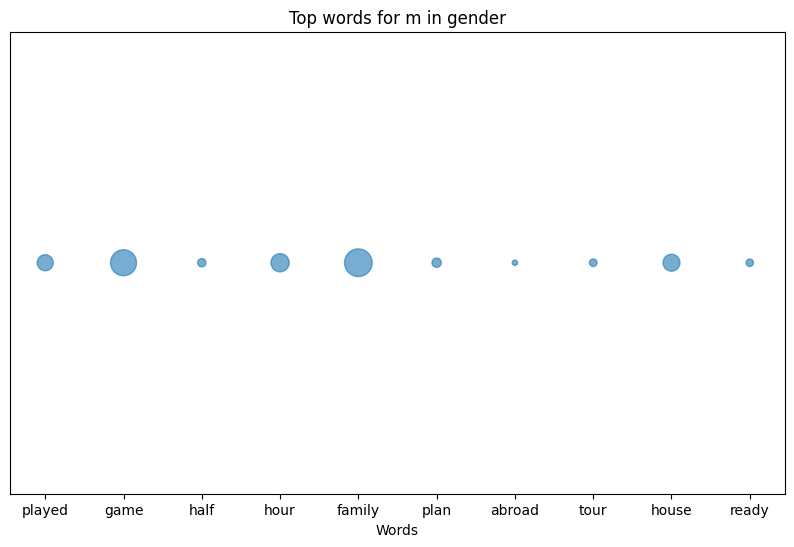

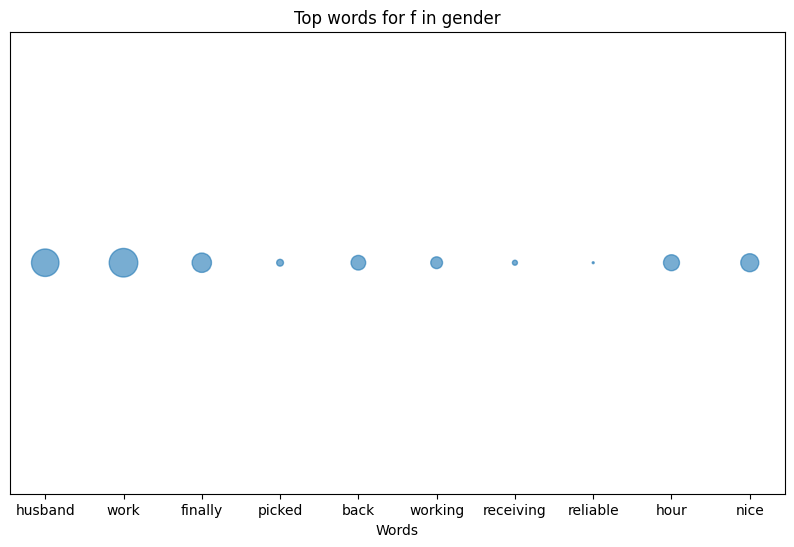

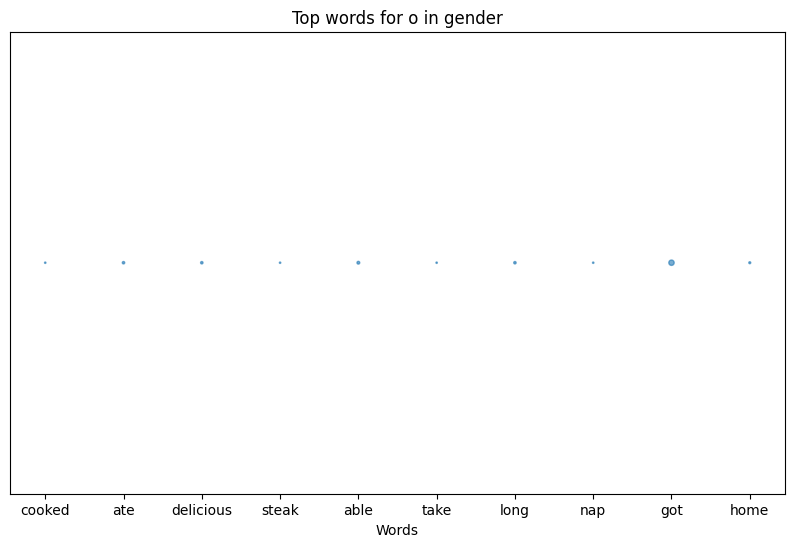

In [ ]:
# Visualization using Bubble Chart
for column, group_data in top_words.items():
    for group, word_counts in group_data.items():
        words = list(word_counts.keys())
        counts = list(word_counts.values())

        # Create bubble chart for each group
        # ensures that the bubbles are evenly spaced along the Y-axis
        plt.figure(figsize=(10, 6))
        plt.scatter(words, [1]*len(words), s=counts, alpha=0.6)

        plt.title(f'Top words for {group} in {column}')
        plt.xlabel('Words')
        plt.yticks([])
        plt.show()

Conclusions:

*   While we observed that the overall happiness sentiment level is approximately the same for both females and males, the leading factors contributing to their happiness differ significantly. For females, the top three words most frequently used in their happy messages are "husband," "work," and "family." In contrast, for males, the top three words are "family," "game," and "house."
*   When comparing the bubble plots for individuals with and without children, a noteworthy pattern emerges. For those who have children,"family," and "friend" rank among their top factors contributing to happiness. In contrast, for individuals without children, "friend" stands out as the primary factor, while "family" is not even among the top factors influencing their happiness.

